## Loading libraries/modules

In [ ]:
import os
import copy

import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sctm
import skimage.io as skio

from scipy.sparse import csr_matrix

/opt/miniconda3/envs/eval_stamp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/eval_stamp/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/eval_stamp/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import Distri

In [2]:
%load_ext autoreload
%autoreload 2

## Loading synthetic data

`anndata` (abbreviated `ad`) is a Python package for handling annotated data
matrices.

**Attributes of `AnnData` objects:**

* `X`: primary data matrix, formatted (cell, gene)
  - Not necessarily raw counts—could be output of some normalization method
* `obs`: cell-level metadata
  - e.g. x-y position of a cell in space
* `var`: gene-level metadata
  - e.g. gene IDs, function, genome
* `obsm`: multi-dimensional cell annotations (dict-like)
* `varm`: multi-dimensional gene annotations (dict-like)
* `layers`: additional data matrices
* `uns`: unstructured annotations
* `raw`: optional copy of unnormalized data
* `obsp/varp`: pairwise cell/cell or gene/gene matrices
  - e.g. adjacency matrices for cells or distances between cells

We read in synthetic data provided by Zhong et al. (2024) below.

In [3]:
syndata = sc.read_h5ad("../data/simulation.h5ad")
syndata

AnnData object with n_obs × n_vars = 1296 × 500
    obs: 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5'
    uns: 'log1p', 'spatial_neighbors'
    obsm: 'nsfac', 'spatial', 'spfac'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

There are 1296 "cells" (arranged in a 36 x 36 grid) and 500 "genes." 

In [4]:
syndata.X.shape

(1296, 500)

The first five rows and columns of `syndata` are shown below:

In [5]:
# First five rows/columns
syndata.X[0:5, 0:5]

array([[0.        , 0.00398406, 0.00039841, 0.        , 0.00119522],
       [0.        , 0.00172968, 0.        , 0.        , 0.00185322],
       [0.        , 0.00207612, 0.00034602, 0.        , 0.00380623],
       [0.        , 0.        , 0.        , 0.00161377, 0.00376547],
       [0.        , 0.00059844, 0.        , 0.00119689, 0.00179533]],
      dtype=float32)

Cell-level metadata (via `syndata.obs`) describes the topic proportions for each
cell. The data under `syndata.obs` likely was the output of running STAMP.

In [6]:
syndata.obs[0:5]

Topic1    Topic2    Topic3    Topic4    Topic5
529   0.002131  0.369869  0.000955  0.279848  0.347197
478   0.001530  0.499530  0.000431  0.207347  0.291163
234   0.000388  0.700785  0.000163  0.297950  0.000714
64    0.349254  0.648572  0.000444  0.001086  0.000645
1087  0.412093  0.263741  0.003173  0.004841  0.316153

There is no gene-level metadata (likely not useful). Additional cell annotations
are listed under `syndata.obsm`, which include:

* `nsfac`: just a (1296, 3) matrix of zeros,
* `spatial`: records spatial coordinates of each cell (all within $[-2, 2]\times [-2, 2]$)
* `spfac`: a (1296, 5) matrix containing true (?) topic proportions

In [7]:
np.all(syndata.obsm["nsfac"] == 0)

np.True_

In [8]:
syndata.obsm["spatial"]

array([[ 0.8571429 ,  0.40000522],
       [-0.8571429 ,  0.5142909 ],
       [ 0.05714297,  1.3142909 ],
       ...,
       [ 0.7428572 , -1.4285663 ],
       [-1.7714286 ,  0.74286234],
       [-1.7714286 , -1.7714235 ]], shape=(1296, 2), dtype=float32)

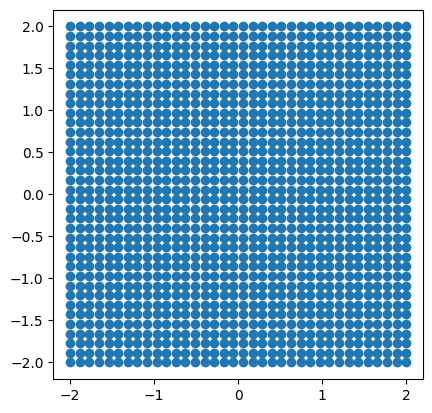

In [9]:
plt.scatter(syndata.obsm["spatial"][:,0], syndata.obsm["spatial"][:,1])
plt.gca().set_aspect(1)

In [10]:
syndata.obsm["spfac"]

array([[0.31744347, 0.        , 0.        , 0.30585055, 0.37670598],
       [0.2496337 , 0.        , 0.        , 0.22511001, 0.5252563 ],
       [0.        , 0.        , 0.        , 0.26453874, 0.73546126],
       ...,
       [0.37368489, 0.36441867, 0.        , 0.        , 0.26189644],
       [0.        , 0.31386302, 0.        , 0.        , 0.68613698],
       [0.        , 0.27908556, 0.40261148, 0.        , 0.31830296]],
      shape=(1296, 5))

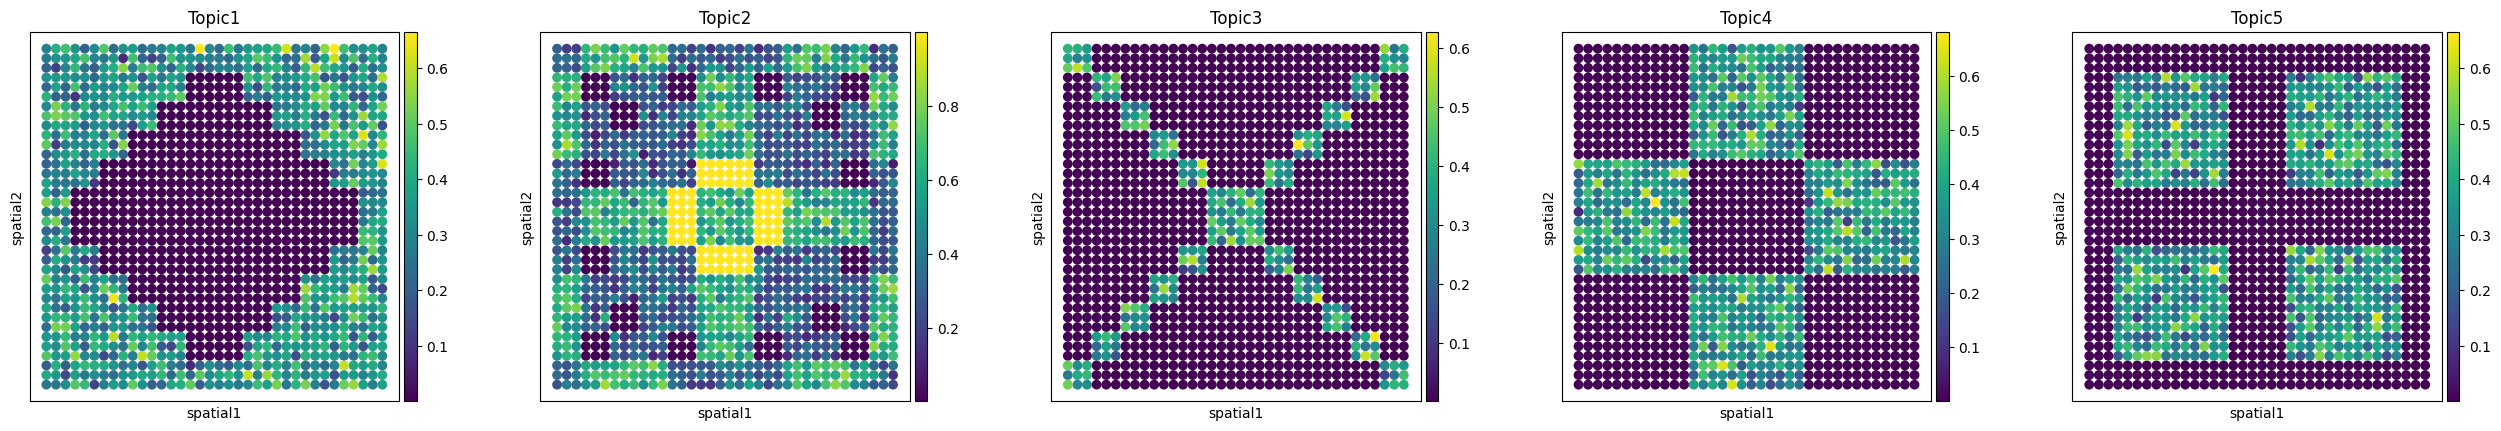

In [11]:
# Visualizing topic proportions for each cell
sctm.pl.spatial(syndata, color=syndata.obs.columns, size=200, ncols=5, wspace=0)

One of the additional data matrices under `syndata.layers` is `counts`, which records
the number of reads for each gene and each cell. The main data matrix `syndata.X`
is just the counts matrix row-normalized.

In [12]:
syndata.layers["counts"]

array([[ 0, 10,  1, ...,  0,  0,  0],
       [ 0, 14,  0, ...,  0,  0,  0],
       [ 0, 12,  2, ...,  0,  0,  0],
       ...,
       [ 0, 15,  0, ..., 61,  0,  0],
       [ 0,  0,  0, ...,  9,  0,  0],
       [ 0,  0,  3, ..., 15,  0,  0]], shape=(1296, 500))

In [13]:
# Checking that syndata.X and syndata.layers["counts"] have the same sparsity
# pattern
np.all((syndata.layers["counts"] > 0) == (syndata.X > 0))

np.True_

In [14]:
# Checking that syndata.X is just syndata.layers["counts"] row-normalized
(syndata.layers["counts"] / syndata.layers["counts"].sum(axis=1)[:, None])[0:10, 0:5]

array([[0.        , 0.00398406, 0.00039841, 0.        , 0.00119522],
       [0.        , 0.00172968, 0.        , 0.        , 0.00185322],
       [0.        , 0.00207612, 0.00034602, 0.        , 0.00380623],
       [0.        , 0.        , 0.        , 0.00161377, 0.00376547],
       [0.        , 0.00059844, 0.        , 0.00119689, 0.00179533],
       [0.        , 0.        , 0.        , 0.        , 0.00302697],
       [0.        , 0.00180072, 0.00030012, 0.00210084, 0.00210084],
       [0.        , 0.00355703, 0.00023714, 0.        , 0.00142281],
       [0.        , 0.00064809, 0.        , 0.00097213, 0.0029164 ],
       [0.        , 0.00322622, 0.00012905, 0.        , 0.00335527]])

In [15]:
syndata.X[0:10, 0:5]

array([[0.        , 0.00398406, 0.00039841, 0.        , 0.00119522],
       [0.        , 0.00172968, 0.        , 0.        , 0.00185322],
       [0.        , 0.00207612, 0.00034602, 0.        , 0.00380623],
       [0.        , 0.        , 0.        , 0.00161377, 0.00376547],
       [0.        , 0.00059844, 0.        , 0.00119689, 0.00179533],
       [0.        , 0.        , 0.        , 0.        , 0.00302697],
       [0.        , 0.00180072, 0.00030012, 0.00210084, 0.00210084],
       [0.        , 0.00355703, 0.00023714, 0.        , 0.00142281],
       [0.        , 0.00064809, 0.        , 0.00097213, 0.0029164 ],
       [0.        , 0.00322622, 0.00012905, 0.        , 0.00335527]],
      dtype=float32)

Cell-cell information is also given in `syndata.obsp`, namely:

* `spatial_connectivities`: adjacency matrix for the cells 
* `spatial_distances`: distances between the cells

/var/folders/qm/twshs_6x0lqbb__gc93b7hk40000gn/T/ipykernel_65172/1507290662.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(syndata.obsp["spatial_connectivities"].toarray())
/opt/miniconda3/envs/eval_stamp/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


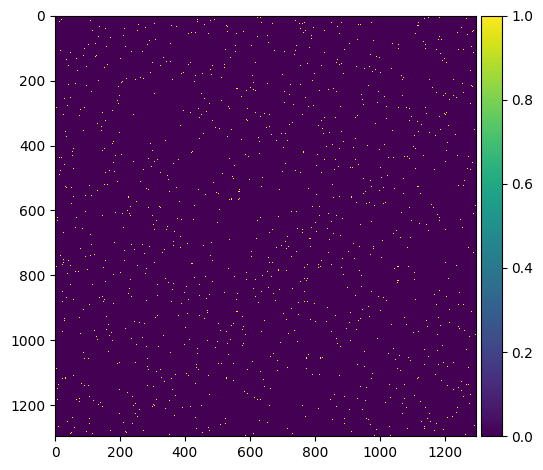

In [16]:
skio.imshow(syndata.obsp["spatial_connectivities"].toarray())

/var/folders/qm/twshs_6x0lqbb__gc93b7hk40000gn/T/ipykernel_65172/922643291.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(syndata.obsp["spatial_distances"].toarray())
/opt/miniconda3/envs/eval_stamp/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


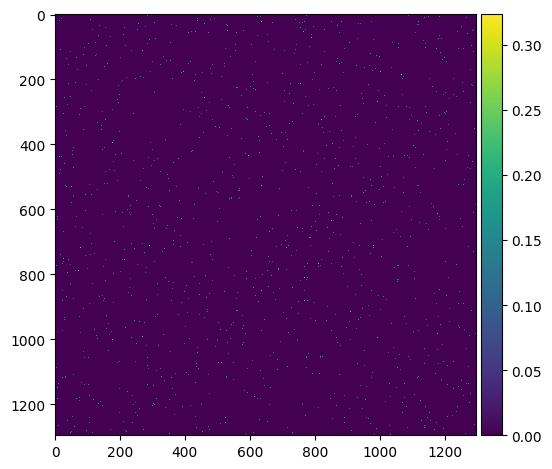

In [17]:
skio.imshow(syndata.obsp["spatial_distances"].toarray())

We display additional (public) attributes of `syndata` below.

In [18]:
np.array([x for x in dir(syndata) if not x.startswith('_')])

array(['T', 'X', 'chunk_X', 'chunked_X', 'concatenate', 'copy', 'file',
       'filename', 'is_view', 'isbacked', 'isview', 'layers', 'n_obs',
       'n_vars', 'obs', 'obs_keys', 'obs_names', 'obs_names_make_unique',
       'obs_vector', 'obsm', 'obsm_keys', 'obsp', 'raw',
       'rename_categories', 'shape', 'strings_to_categoricals', 'to_df',
       'to_memory', 'transpose', 'uns', 'uns_keys', 'var', 'var_keys',
       'var_names', 'var_names_make_unique', 'var_vector', 'varm',
       'varm_keys', 'varp', 'write', 'write_csvs', 'write_h5ad',
       'write_loom', 'write_zarr'], dtype='<U23')

## Visualizing the synthetic data

The ground truth topic proportions for each cell are visualized below. 

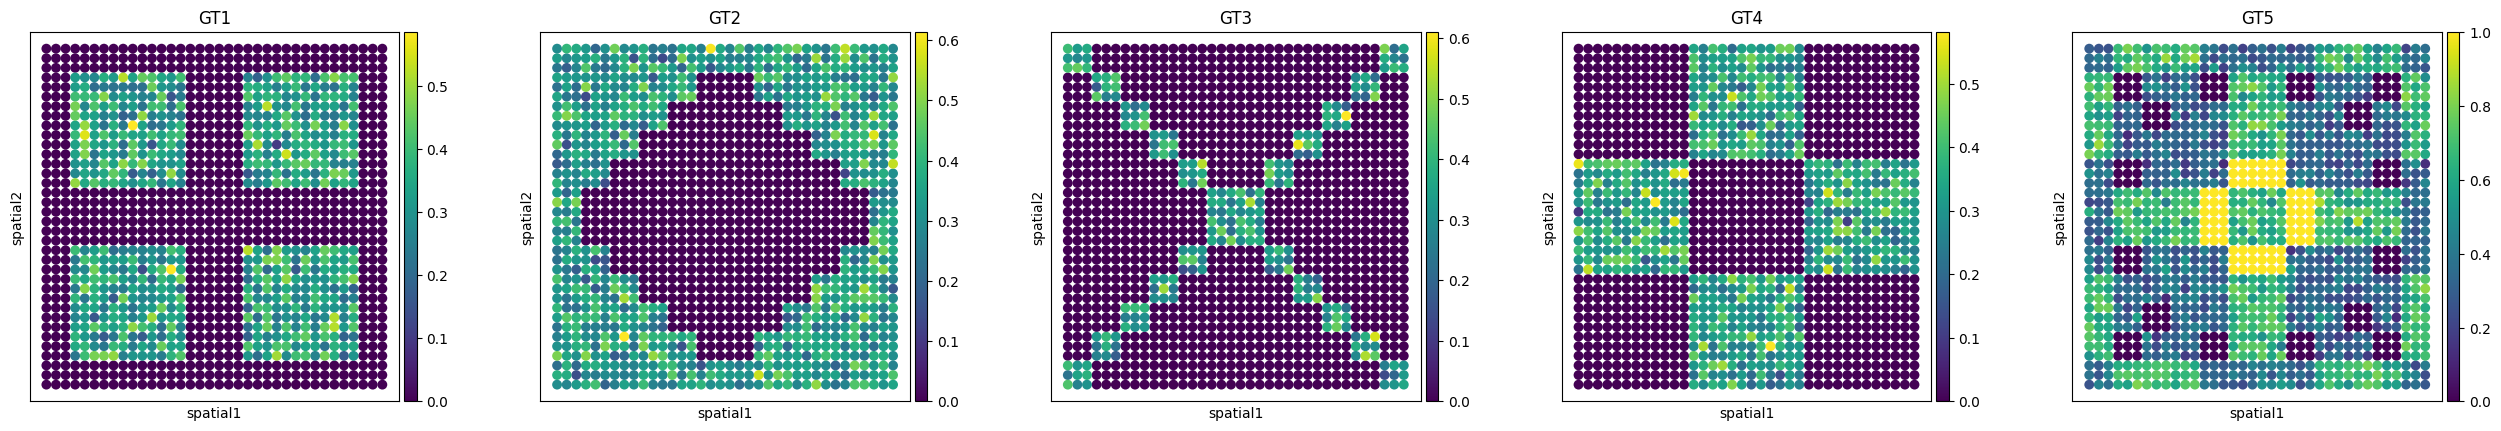

In [19]:
# Putting ground truth topic proportions from syndata.obsm['spfac'] into a 
# dataframe
gt = pd.DataFrame(syndata.obsm['spfac'], 
                  index = syndata.obs_names, 
                  columns = [f"GT{i}" for i in range(1,6)])

# Adding columns of gt to syndata.obs
for i in gt.columns:
    syndata.obs[i] = gt[i]

# Coloring cells by topic proportions given in syndata.obsm['spfac']
sctm.pl.spatial(syndata, color=gt.columns, size=200, ncols=5, wspace=0)

In [20]:
syndata.obs.head()

Topic1    Topic2    Topic3    Topic4    Topic5       GT1       GT2  \
529   0.002131  0.369869  0.000955  0.279848  0.347197  0.317443  0.000000   
478   0.001530  0.499530  0.000431  0.207347  0.291163  0.249634  0.000000   
234   0.000388  0.700785  0.000163  0.297950  0.000714  0.000000  0.000000   
64    0.349254  0.648572  0.000444  0.001086  0.000645  0.000000  0.360456   
1087  0.412093  0.263741  0.003173  0.004841  0.316153  0.279358  0.418526   

      GT3       GT4       GT5  
529   0.0  0.305851  0.376706  
478   0.0  0.225110  0.525256  
234   0.0  0.264539  0.735461  
64    0.0  0.000000  0.639544  
1087  0.0  0.000000  0.302116

The spatial expression patterns for the first first genes in the dataset
are shown below. 

* First gene is not expressed in any of the cells.
* Second gene's expression pattern resembles a mix of topics 1 and 4.

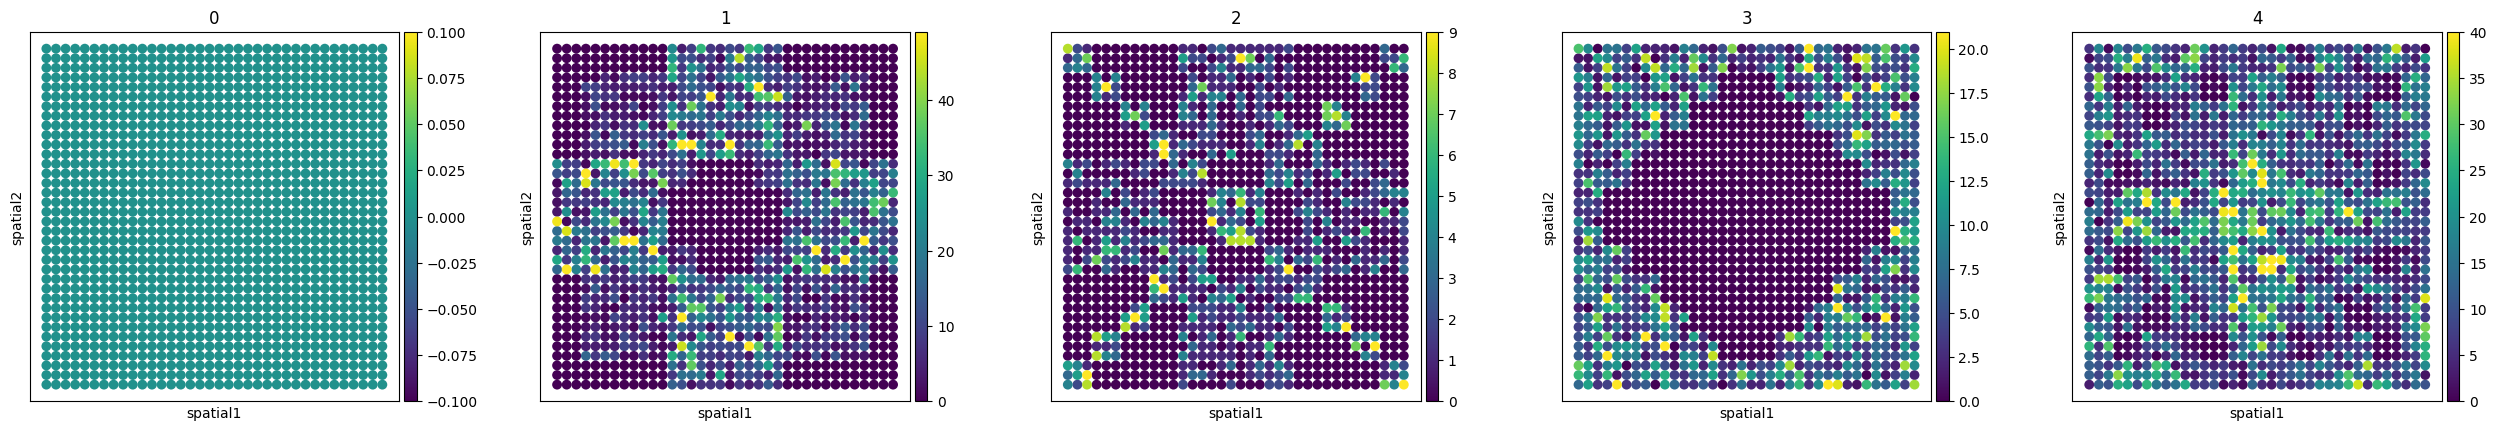

In [21]:
sctm.pl.spatial(syndata, color=syndata.var_names[:5], 
                ncols=5, size=200, vmax='p99', wspace=0,
                layer='counts')

## Performing inference with STAMP

### Reproducing demo from STAMP documentation

In [26]:
syndata_model = sctm.stamp.STAMP(
    syndata,
    n_topics=5,
    layer="counts",
    gene_likelihood="nb"
)

Computing background frequencies


In [27]:
# In the demo:
syndata_model.train(
    learning_rate=0.01, 
    batch_size=1296, 
    shuffle=True, 
    min_epochs=800,
    device="cpu")

  0%|          | 0/800 [00:00<?, ?it/s]/opt/miniconda3/envs/eval_stamp/lib/python3.10/site-packages/pyro/primitives.py:478: UserWarning: encoder.norm_topic.0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
Epoch Loss:802.295: 100%|██████████| 800/800 [00:31<00:00, 25.43it/s]


In [28]:
topic_prop = syndata_model.get_cell_by_topic()
beta = syndata_model.get_feature_by_topic(pseudocount = 0.3)
for i in topic_prop.columns:
    syndata.obs[i] = topic_prop[i]

In [29]:
syndata.obs

Topic1    Topic2    Topic3    Topic4    Topic5           GT1  \
529   0.309226  0.039871  0.392552  0.230596  0.027755  3.174435e-01   
478   0.235035  0.025041  0.529984  0.192329  0.017612  2.496337e-01   
234   0.262592  0.022155  0.684161  0.018337  0.012755  0.000000e+00   
64    0.051130  0.295074  0.606201  0.028310  0.019285  0.000000e+00   
1087  0.077301  0.324999  0.328362  0.235711  0.033627  2.793584e-01   
...        ...       ...       ...       ...       ...           ...   
956   0.172107  0.025748  0.763818  0.023123  0.015204  4.192907e-55   
734   0.015623  0.013778  0.954397  0.009549  0.006653  0.000000e+00   
1104  0.052748  0.341729  0.266614  0.314351  0.024558  3.736849e-01   
398   0.033825  0.285541  0.646547  0.019828  0.014259  0.000000e+00   
1190  0.049231  0.275718  0.281817  0.027249  0.365985  0.000000e+00   

           GT2       GT3       GT4       GT5  
529   0.000000  0.000000  0.305851  0.376706  
478   0.000000  0.000000  0.225110  0.525256  
234   0.000000  0.000000  0.264539  0.735461  
64    0.360456  0.000000  0.000000  0.639544  
1087  0.418526  0.000000  0.000000  0.302116  
...        ...       ...       ...       ...  
956   0.000000  0.000000  0.201447  0.798553  
734   0.000000  0.000000  0.000000  1.000000  
1104  0.364419  0.000000  0.000000  0.261896  
398   0.313863  0.000000  0.000000  0.686137  
1190  0.279086  0.402611  0.000000  0.318303  

[1296 rows x 10 columns]

We visualize the inferred topic proportions for each cell below.

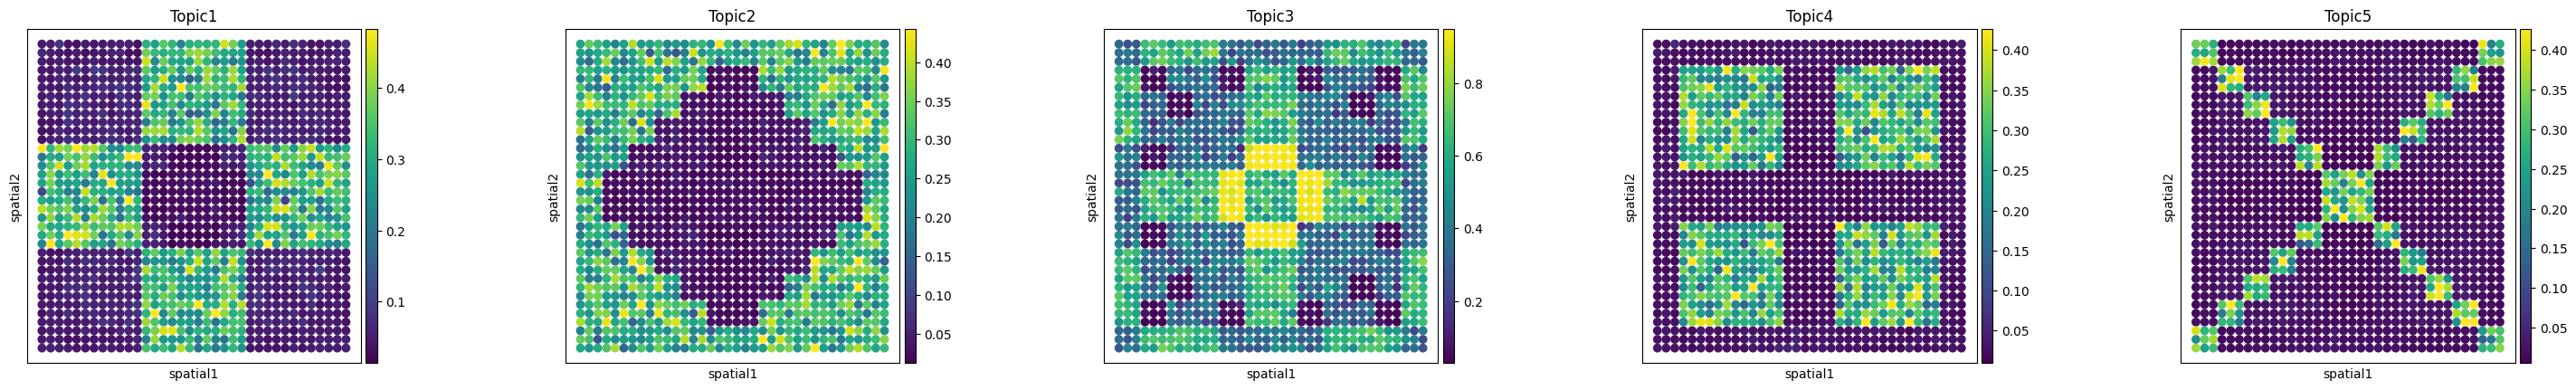

In [30]:
sctm.pl.spatial(
    adata=syndata, 
    color=topic_prop.columns, 
    size=200, 
    layer="counts", 
    vmax='p99', 
    ncols=5
)

### Removing spatial information from `syndata`

Spatial information is given in `syndata.obsm["spatial]` and `syndata.obsp`. 
Based on the source code, only the `obsp` attribute is called. 

In [31]:
syndata_nsp = copy.deepcopy(syndata)

In [32]:
syndata_nsp

AnnData object with n_obs × n_vars = 1296 × 500
    obs: 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'GT1', 'GT2', 'GT3', 'GT4', 'GT5'
    uns: 'log1p', 'spatial_neighbors'
    obsm: 'nsfac', 'spatial', 'spfac'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [33]:
# Setting adjacency and distance matrices to all 0s
syndata_nsp.obsp["spatial_connectivities"] = csr_matrix((1296, 1296))
syndata_nsp.obsp["spatial_distances"] = csr_matrix((1296, 1296))

We perform inference with the modified synthetic dataset below.

In [34]:
syndata_nsp_model = sctm.stamp.STAMP(
    syndata,
    n_topics=5,
    layer="counts",
    gene_likelihood="nb"
)

Computing background frequencies


In [35]:
syndata_nsp_model.train(
    learning_rate=0.01, 
    batch_size=1296, 
    shuffle=True, 
    min_epochs=800,
    device="cpu"
)

  0%|          | 0/800 [00:00<?, ?it/s]/opt/miniconda3/envs/eval_stamp/lib/python3.10/site-packages/pyro/primitives.py:478: UserWarning: encoder.norm_topic.0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
Epoch Loss:802.824: 100%|██████████| 800/800 [00:30<00:00, 26.34it/s]


In [36]:
topic_prop_nsp = syndata_nsp_model.get_cell_by_topic()
beta_nsp = syndata_nsp_model.get_feature_by_topic(pseudocount = 0.3)
for i in topic_prop_nsp.columns:
    syndata_nsp.obs[i] = topic_prop_nsp[i]

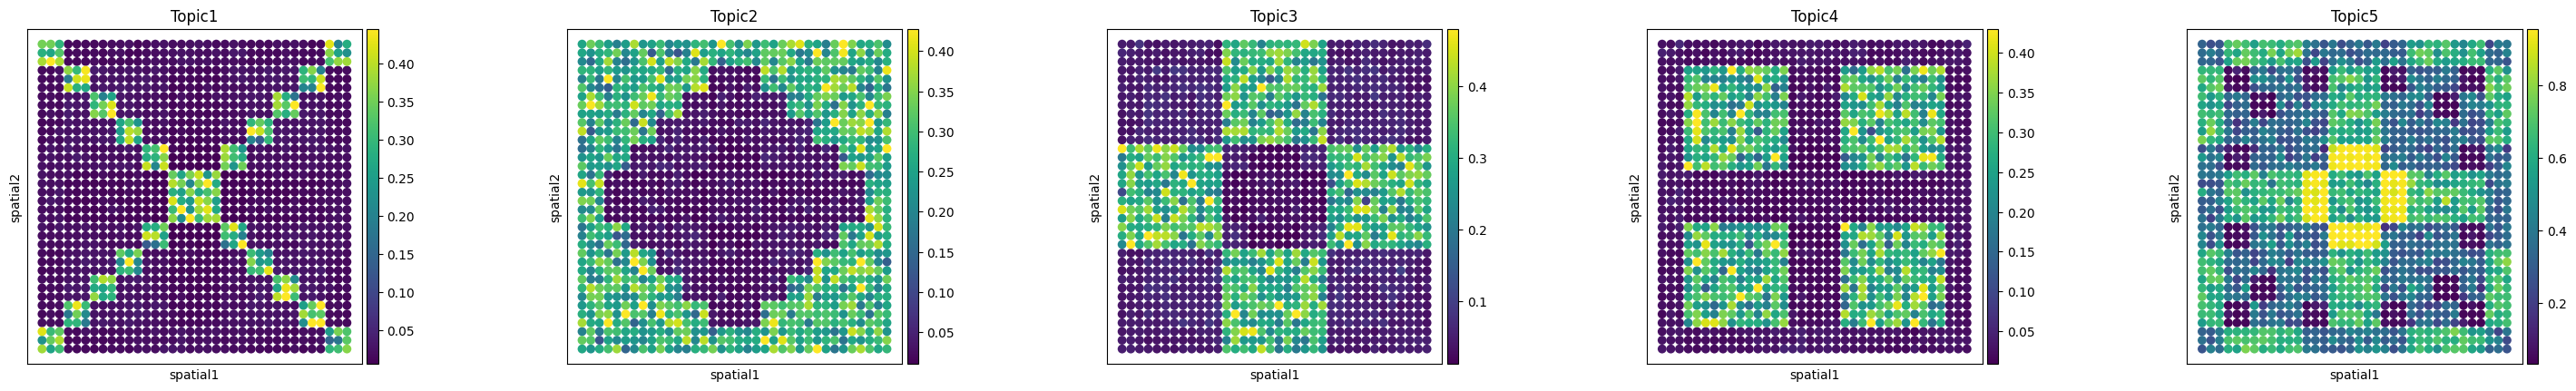

In [37]:
# Without spatial data
sctm.pl.spatial(
    adata=syndata_nsp, 
    color=topic_prop_nsp.columns, 
    size=200, 
    layer="counts", 
    vmax='p99',
    ncols=5
)

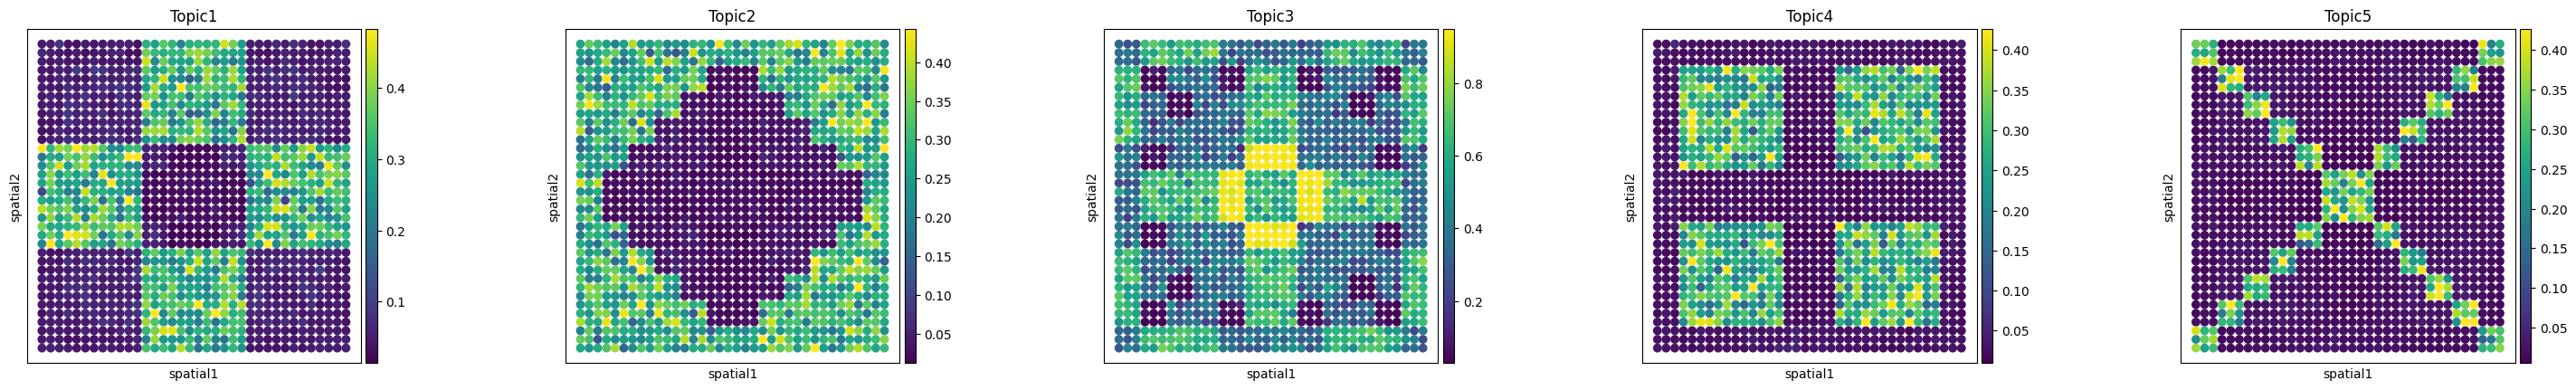

In [38]:
# With spatial data
sctm.pl.spatial(
    adata=syndata, 
    color=topic_prop_nsp.columns, 
    size=200, 
    layer="counts", 
    vmax='p99',
    ncols=5
)

In [39]:
syndata_nsp.obs.head()

Topic1    Topic2    Topic3    Topic4    Topic5       GT1       GT2  \
529   0.025530  0.039322  0.310923  0.236284  0.387940  0.317443  0.000000   
478   0.016354  0.024346  0.231528  0.199726  0.528046  0.249634  0.000000   
234   0.012011  0.022583  0.258700  0.018020  0.688686  0.000000  0.000000   
64    0.019225  0.281421  0.046267  0.026755  0.626331  0.000000  0.360456   
1087  0.033960  0.311151  0.076658  0.241366  0.336865  0.279358  0.418526   

      GT3       GT4       GT5  
529   0.0  0.305851  0.376706  
478   0.0  0.225110  0.525256  
234   0.0  0.264539  0.735461  
64    0.0  0.000000  0.639544  
1087  0.0  0.000000  0.302116

In [40]:
syndata.obs.head()

Topic1    Topic2    Topic3    Topic4    Topic5       GT1       GT2  \
529   0.309226  0.039871  0.392552  0.230596  0.027755  0.317443  0.000000   
478   0.235035  0.025041  0.529984  0.192329  0.017612  0.249634  0.000000   
234   0.262592  0.022155  0.684161  0.018337  0.012755  0.000000  0.000000   
64    0.051130  0.295074  0.606201  0.028310  0.019285  0.000000  0.360456   
1087  0.077301  0.324999  0.328362  0.235711  0.033627  0.279358  0.418526   

      GT3       GT4       GT5  
529   0.0  0.305851  0.376706  
478   0.0  0.225110  0.525256  
234   0.0  0.264539  0.735461  
64    0.0  0.000000  0.639544  
1087  0.0  0.000000  0.302116

## Random ideas

* What if we set the adjacency matrix to be all ones expect for the diagonal?
  This assumes that all cells are connected.